<h1> Airline Satisfaction </h1>

<h2> Import libraries </h2>

In [43]:
# Data Handling
import pandas as pd, numpy as np

# Plotting
import matplotlib.pyplot as plt, seaborn as sns

# Data transform
from sklearn.preprocessing import RobustScaler, OneHotEncoder

# Metrics
from sklearn.metrics import balanced_accuracy_score, f1_score, ConfusionMatrixDisplay

# 2D Plotting
import umap.umap_ as umap
from plot_umap import draw_umap

# Tomeks Links
from imblearn.under_sampling import TomekLinks

# Model Accesories 
import time
from sklearn.model_selection import train_test_split
from Classifier_evaluation import test_classifiers
# from sklearn.utils import class_weight

# Models used
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier 
from sklearn.linear_model import LogisticRegression, RidgeClassifier

# Hyperparameter optimization
import optuna

# Feature Importances
import shap

# Notebook Management
import gc as gc
gc.enable()
from joblib import dump, load
from warnings import filterwarnings
filterwarnings('ignore')
shap.initjs()

In [11]:
# Load the training data
train = pd.read_csv('../airline_satisfaction/train.csv')
# Drop unnecessary columns
train.drop(['id', 'Unnamed: 0'], inplace=True, axis=1)
train.head(n=10)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied
5,Female,Loyal Customer,26,Personal Travel,Eco,1180,3,4,2,1,...,1,3,4,4,4,4,1,0,0.0,neutral or dissatisfied
6,Male,Loyal Customer,47,Personal Travel,Eco,1276,2,4,2,3,...,2,3,3,4,3,5,2,9,23.0,neutral or dissatisfied
7,Female,Loyal Customer,52,Business travel,Business,2035,4,3,4,4,...,5,5,5,5,4,5,4,4,0.0,satisfied
8,Female,Loyal Customer,41,Business travel,Business,853,1,2,2,2,...,1,1,2,1,4,1,2,0,0.0,neutral or dissatisfied
9,Male,disloyal Customer,20,Business travel,Eco,1061,3,3,3,4,...,2,2,3,4,4,3,2,0,0.0,neutral or dissatisfied


After dropping the unnecesary columns, the dataset shows 22 features and a target, which is wether the customer is "satisfied" or "neutral or dissatisfied". This is a binary classification problem and it can be simplified to a boolean.

In [12]:
# Convert class to 1 or 0
train['satisfaction'] = [1 if x=='satisfied' else 0 for x in train['satisfaction']]
# Evaluate % of each class
train['satisfaction'].value_counts(normalize=True)

0    0.566667
1    0.433333
Name: satisfaction, dtype: float64

Now, let's analyze the features

In [13]:
for col in train.columns:
    print(col)

Gender
Customer Type
Age
Type of Travel
Class
Flight Distance
Inflight wifi service
Departure/Arrival time convenient
Ease of Online booking
Gate location
Food and drink
Online boarding
Seat comfort
Inflight entertainment
On-board service
Leg room service
Baggage handling
Checkin service
Inflight service
Cleanliness
Departure Delay in Minutes
Arrival Delay in Minutes
satisfaction


Most of these features are integers between 0 and 5 that represent a star system. There is not a proper explaination in the exercise clarifying if the 1 stans for "totally satisfied" or "totally dissatisfied", but it is possible to assume for the moment that it's an linear system, wether ascendant or descendant. For the moment, there is no need to compromise to any premise because the EDA will probably show how this is structured.

As stated, the star ranking stands for levels of satisfaction, guessing it goes from "Totally dissatisfied" to "Totally satisfied", and this is a behaviour more characteristic of an object, rather than an integer, for the initial layout of the dataset. Same reasoning stands for the rest of the features that represent clearly categorical behaviour, like "Customer type", "Gender" or "Type of travel".

In [14]:
# After manual review, determine the appropriate datatypes for each feature
types_dict = {'Gender': 'object', 'Customer Type': 'object', 'Age': 'int64', 'Type of Travel': 'object', 'Class': 'object', 'Flight Distance': 'int64',
              'Inflight wifi service': 'object', 'Departure/Arrival time convenient': 'object', 'Ease of Online booking': 'object', 'Gate location': 'object',
              'Food and drink': 'object', 'Online boarding': 'object', 'Seat comfort': 'object', 'Inflight entertainment': 'object', 'On-board service': 'object',
              'Seat comfort': 'object', 'Inflight entertainment': 'object', 'On-board service': 'object', 'Leg room service': 'object', 'Baggage handling': 'object',
              'Checkin service': 'object', 'Inflight service': 'object', 'Cleanliness': 'object', 'Departure Delay in Minutes': 'float64', 'Arrival Delay in Minutes': 'float64',
              'satisfaction': 'bool'}        


# Set dtypes
train = train.astype(types_dict)

<h2> Exploratory Data Analysis </h2>

In [15]:
# Set plot configuration
sns.set_style("darkgrid")
plt.figure(figsize=(10,8))

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

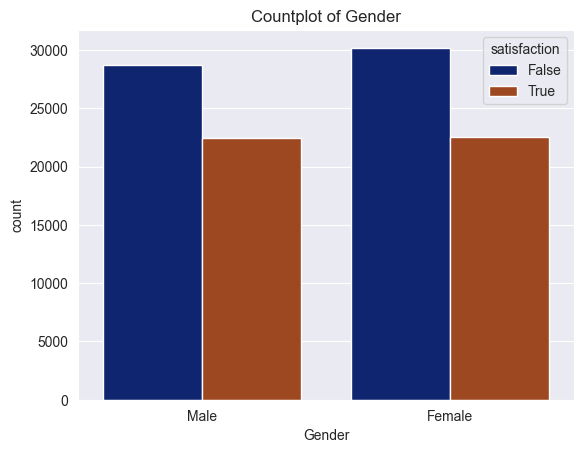

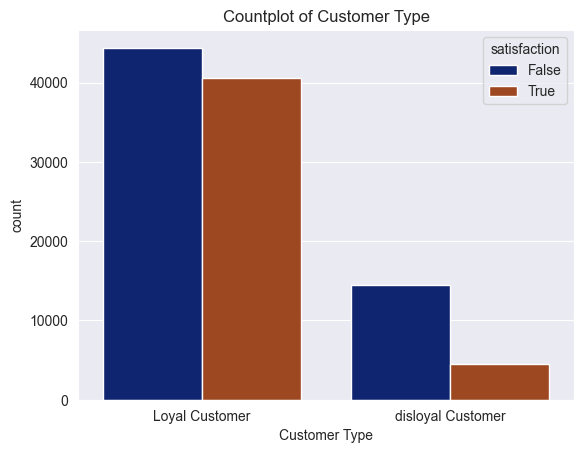

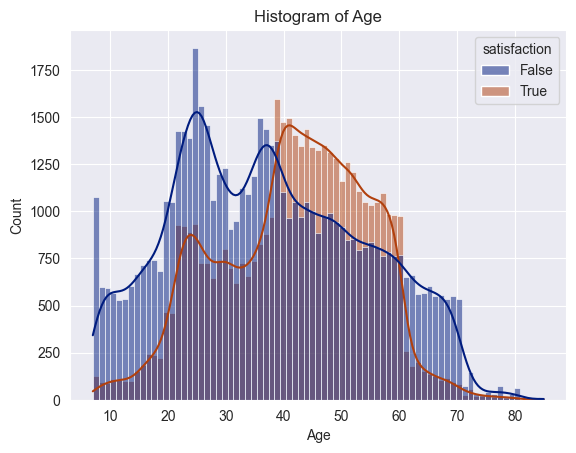

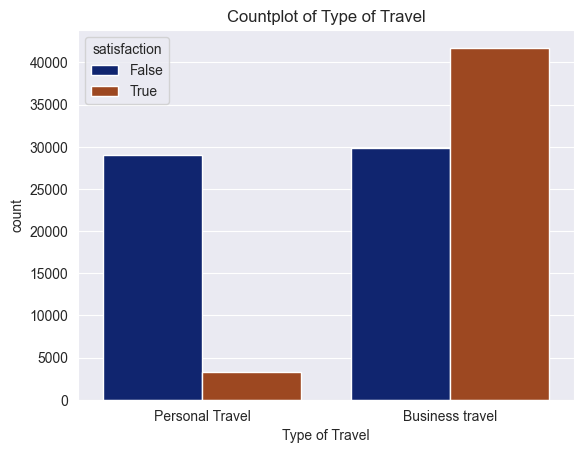

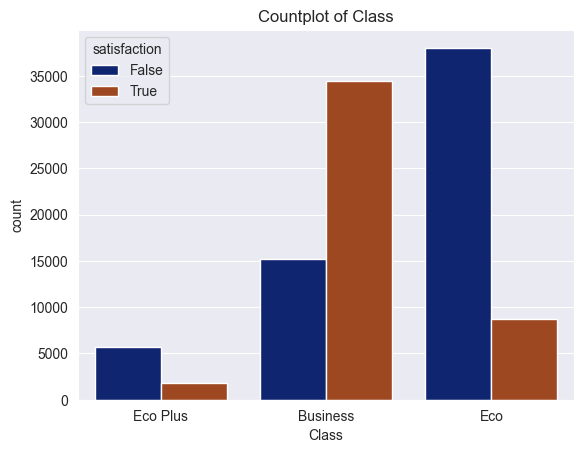

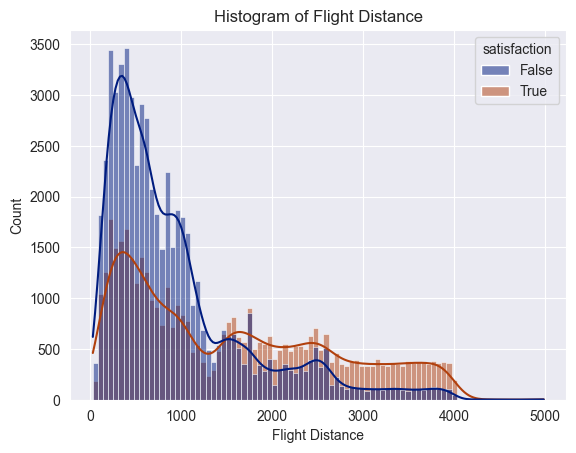

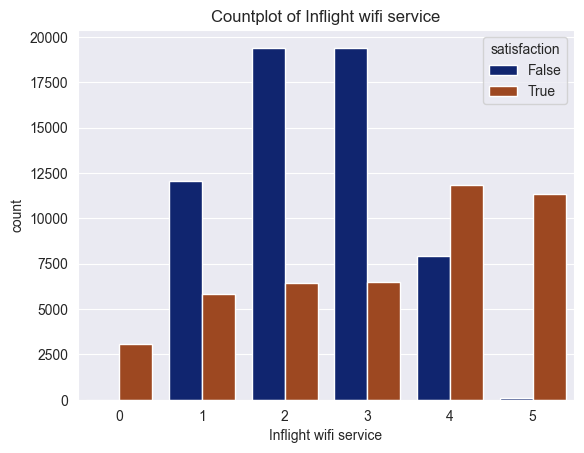

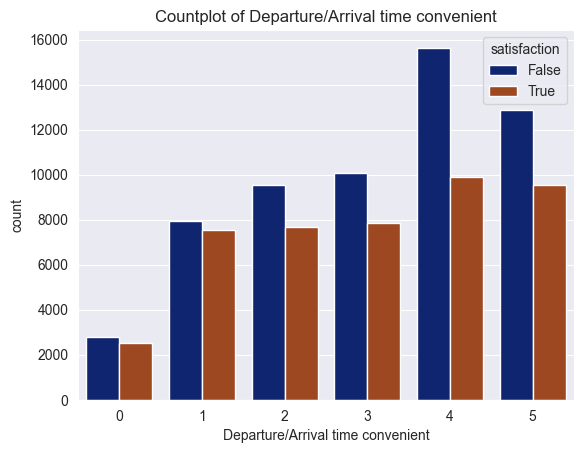

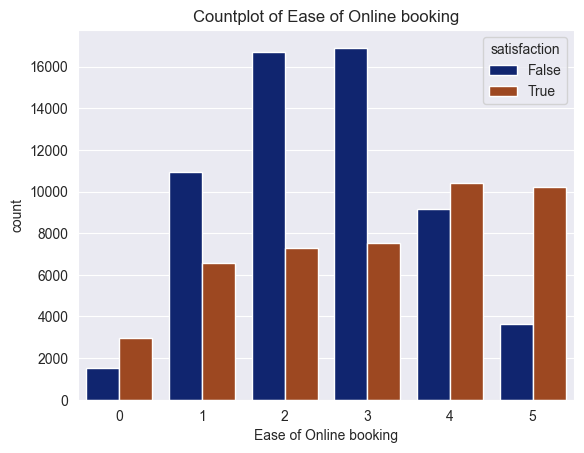

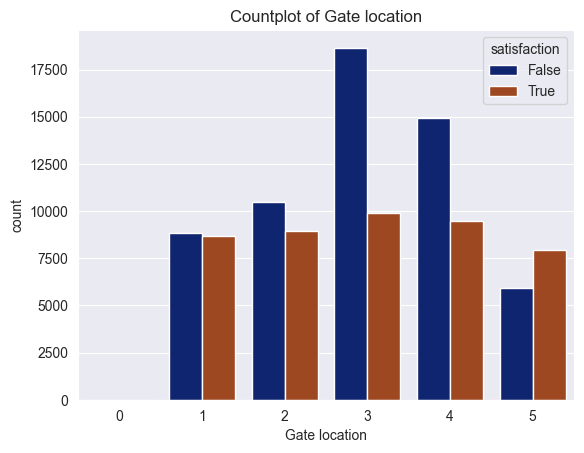

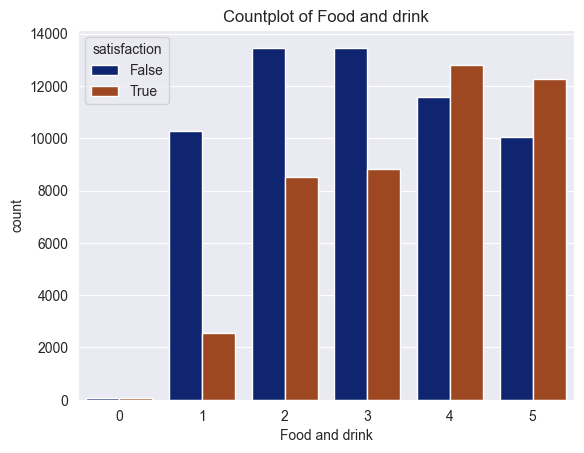

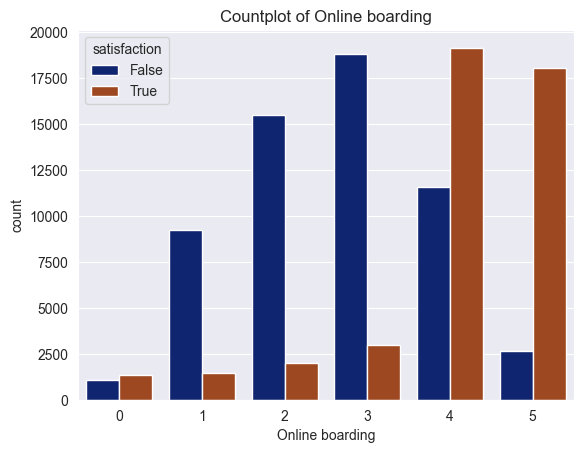

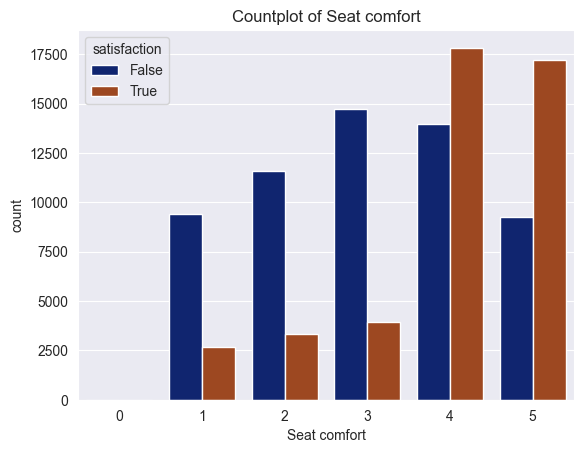

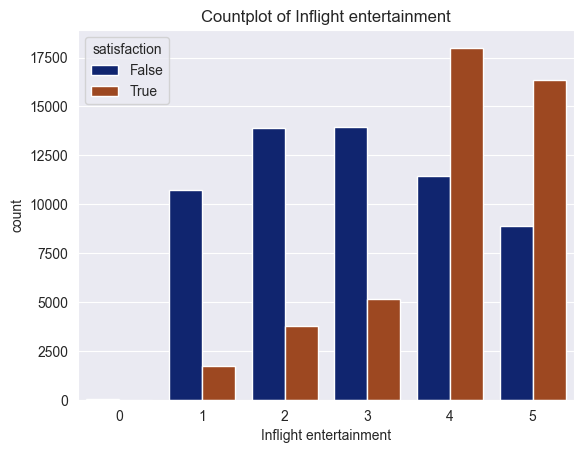

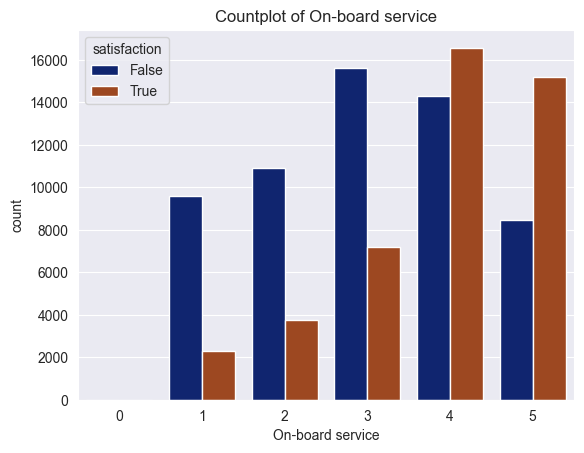

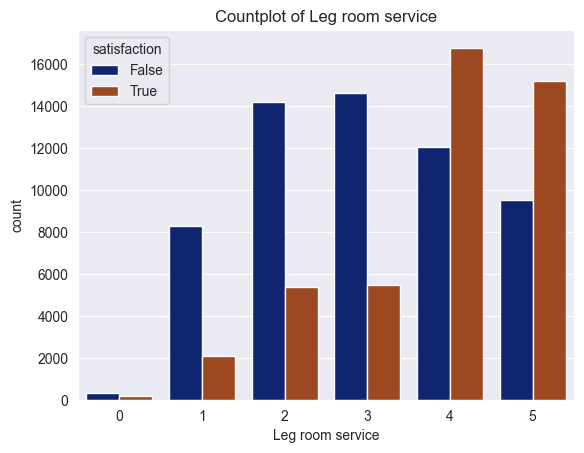

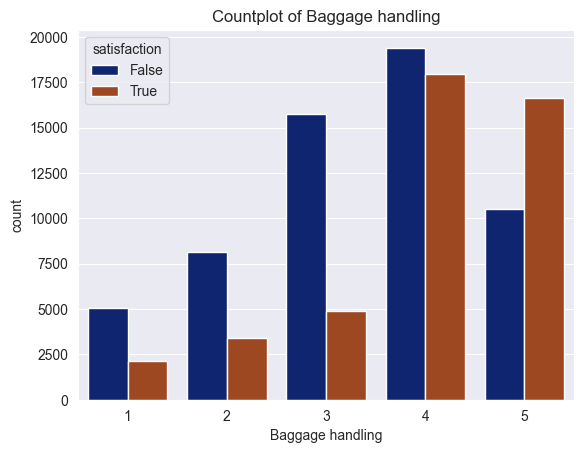

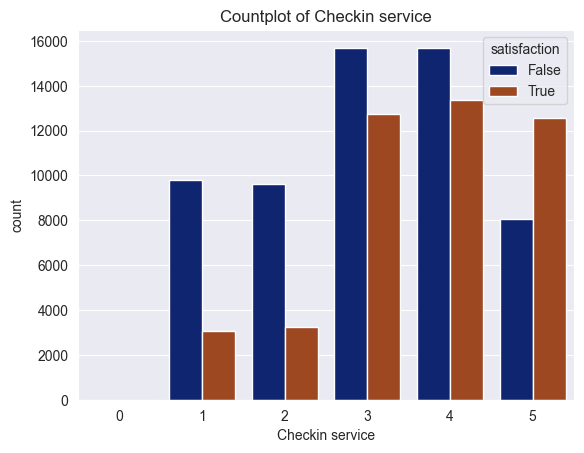

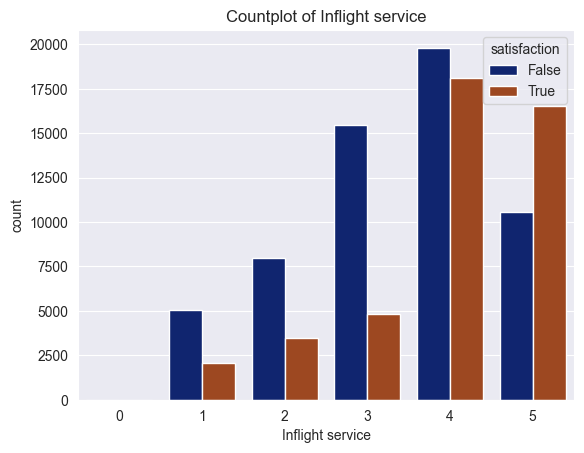

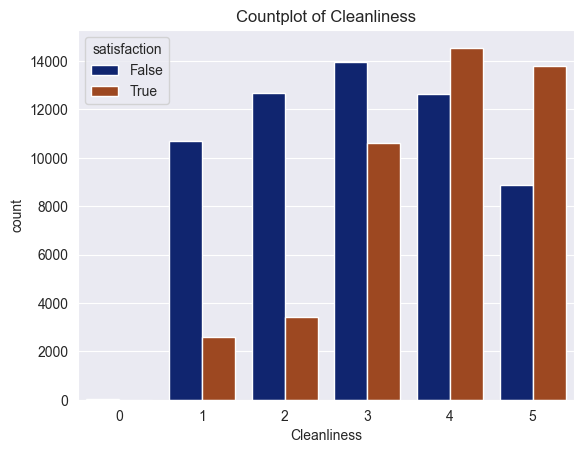

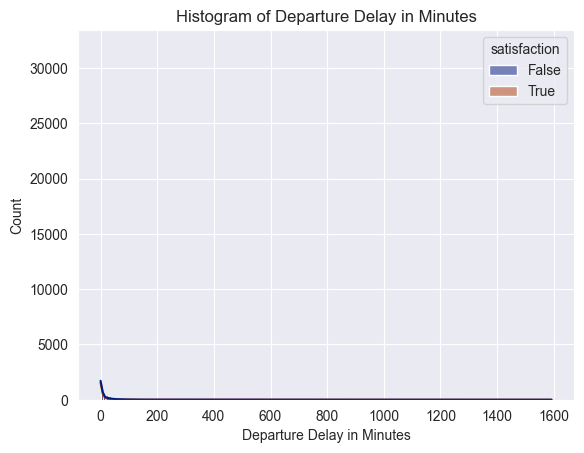

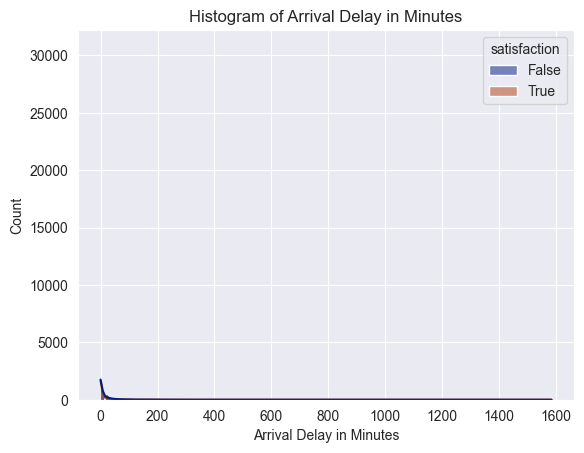

In [16]:
# Feature distribution by class

for col in [x for x in train.columns if x != 'satisfaction']:
    if train[col].dtype in ['int64', 'float64']:
        sns.histplot(data=train, x=col, hue='satisfaction', kde=True, palette="dark").set(title="Histogram of {}".format(str(col)))
        plt.show()
    else:
        sns.countplot(x=col, data=train, hue='satisfaction', palette="dark").set(title="Countplot of {}".format(str(col)))
        plt.show()

There is a lot of information coming from these plots. Let's elaborate the first hypothesis:

    - Most people are dissatisfied for both genders, which means that it's not a very relevant feature to determinate the satisfaction of the customer.
    - Same reasoning for the loyalty of the customer, but it's interesting to see that most of the customers of the dataset are loyal to the airline.
    - Young (younger than 40yo) and old (older than 60yo) customers are generally dissatisfied and middle age (between both borders) the opposite.
    - Most people not travelling for business didn't have a good experience. This is a very strong trend that could be very relevant. 
    - People travelling for business generally book the business class and shares the trend with the previous point made.
    - Longer flights have more satisfied customers. Need to further analyze the relationship with other features.

Among the "star ranking" features, it's possible to conclude now that assigning a 5 to a service means that the customer was satisfied with it, since the overall satisfaction is likely to be positive in most cases when this happened, and the counterpart shares the opposite behaviour. Ranking 0 in a service seems to be a different option apart from the ranking (maybe an empty box, or meaning that the customer doesn't have an opionion on it), since it "breaks" the evolving nature of the system and it has very low representation.

    - There is a really strong trend in features like "wifi service", "online boarding", "inflight entertainment" and "seat comfort": A passanger that was satisfied with any of these features was more likely to be satisfied overall and the other way around.
    

In [17]:
# Create printouts of each feature by class
for col in train.columns:
    print("====== {} ======".format(col))
    if train[col].dtype == 'object':
        print(train.pivot_table(index=['satisfaction'], columns=col, aggfunc='size', fill_value=0))
        print()    
    else:
        print(train[col].describe().T)
        print()

====== Gender ======
Gender        Female   Male
satisfaction               
False          30193  28686
True           22534  22491

====== Customer Type ======
Customer Type  Loyal Customer  disloyal Customer
satisfaction                                    
False                   44390              14489
True                    40533               4492

====== Age ======
count    103904.000000
mean         39.379706
std          15.114964
min           7.000000
25%          27.000000
50%          40.000000
75%          51.000000
max          85.000000
Name: Age, dtype: float64

====== Type of Travel ======
Type of Travel  Business travel  Personal Travel
satisfaction                                    
False                     29909            28970
True                      41746             3279

====== Class ======
Class         Business    Eco  Eco Plus
satisfaction                           
False            15185  38044      5650
True             34480   8701      1844

=====

Arrival and departure delay have a maximum value of over 1500 minutes and the percentile 75 is around 12~13 minutes in both cases. This is an indicator for outliers and explain why the plot in the previous point was not representative at all. They will be handled in the next point

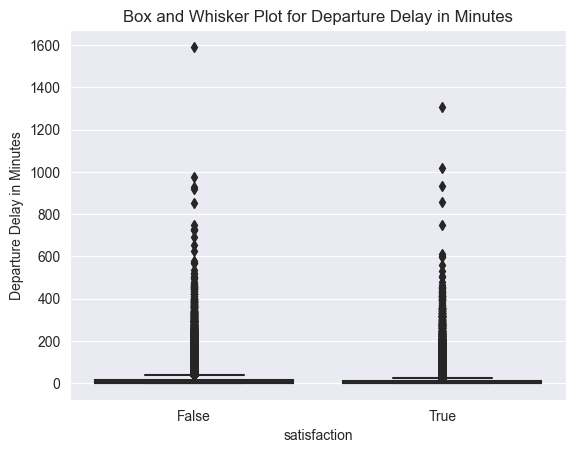

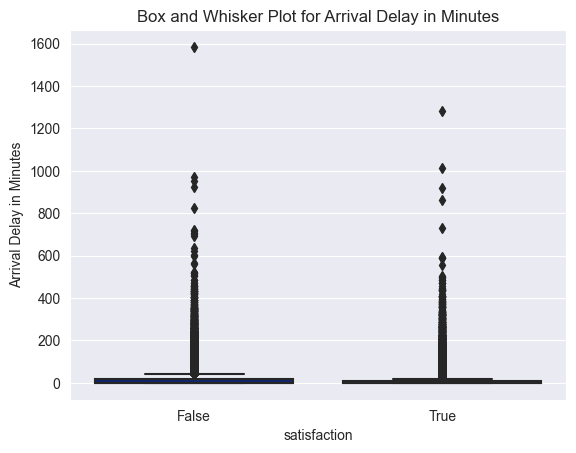

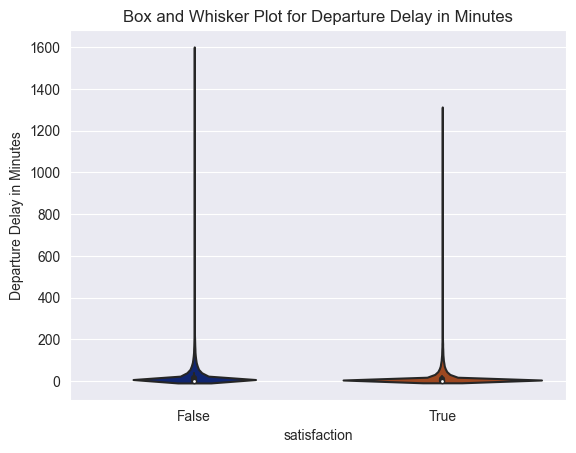

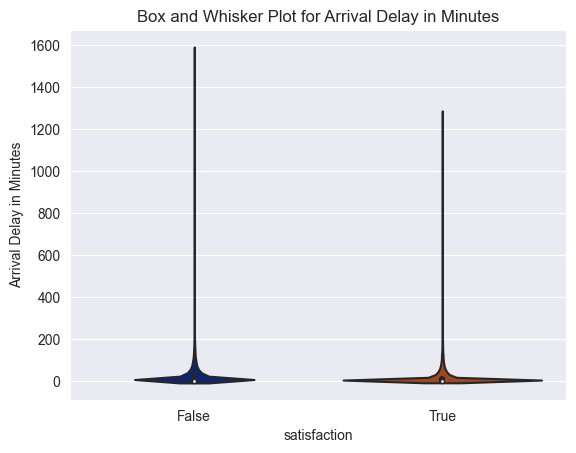

In [18]:
for col in train.columns:
    if 'Delay' in str(col):
        sns.boxplot(data=train, x='satisfaction', y=col, palette="dark").set(title="Box and Whisker Plot for {}".format(str(col)))
        plt.show()

# using violinplots
for col in train.columns:
    if 'Delay' in str(col):
        sns.violinplot(data=train, x='satisfaction', y=col, palette="dark").set(title="Box and Whisker Plot for {}".format(str(col)))
        plt.show()

<h2> Data Preparation </h2>

First let's check the missing values

In [19]:
percent_missing = train.isnull().sum() * 100 / train.shape[0]
missing_value_df = pd.DataFrame({'column_name': train.columns,
                                 'percent_missing': percent_missing,
                                 'type': train.dtypes})

missing_value_df

,column_name,percent_missing,type
Gender,Gender,0.000000,object
Customer Type,Customer Type,0.000000,object
Age,Age,0.000000,int64
Type of Travel,Type of Travel,0.000000,object
Class,Class,0.000000,object
Flight Distance,Flight Distance,0.000000,int64
Inflight wifi service,Inflight wifi service,0.000000,object
Departure/Arrival time convenient,Departure/Arrival time convenient,0.000000,object
Ease of Online booking,Ease of Online booking,0.000000,object
Gate location,Gate location,0.000000,object


There are only missing values in the Arrival Delay in minutes. The assumption will be that there was not a delay if the value was missing.

To handle the outliers of the delay times, a Robust Scaler was used, set to the percentiles 20 and 80, wider than the used in the Tukey method.

In order to take a deeper look into the data distribution, and since the dataset has a rather low amount of features to compute locally, a visualization of the data distribution in 2D will be made using the UMAP algorithm (McInnes, L, Healy, J, UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction, ArXiv e-prints 1802.03426, 2018) which performs a dimensional reduction of the features of study to appreciate how they are grouped in clusters.

As stated, the amount of features is not so high so it's possible to one hot encode the categorical variables for a better analysis. 

In [20]:
train['Arrival Delay in Minutes'].fillna(0, inplace=True)

# Handle and process the data
numerical_columns = [x for x in train.columns if train[x].dtype != 'object' and x != 'satisfaction']
cat_columns = [x for x in train.columns if x not in numerical_columns and x != 'satisfaction']

# Use a robust outlier to handle the delay features
rs = RobustScaler(quantile_range=(20,80))

train['Arrival Delay in Minutes'] = rs.fit_transform(train['Arrival Delay in Minutes'].to_numpy().reshape(-1,1))
train['Departure Delay in Minutes'] = rs.fit_transform(train['Departure Delay in Minutes'].to_numpy().reshape(-1,1))


# One hot encoding categorical data
ohe = OneHotEncoder(handle_unknown="ignore", sparse=False, drop='first')
encoded_data = pd.DataFrame(data=ohe.fit_transform(train[cat_columns]), columns=ohe.get_feature_names_out())

# Create a dataframe of the data prepped for modeling
modeling_data = pd.concat([train[numerical_columns], encoded_data], axis=1)

# Determine the categorical columns for the modeling dataframe
modeling_cat_cols = [col for col in modeling_data.columns if col not in ['Age', 'Flight Distance', 'Departure Delay in Minutes','Arrival Delay in Minutes']]

In [21]:
# Change types to category
for col in modeling_cat_cols:
    modeling_data[col] = modeling_data[col].astype('category')

In [22]:
len(modeling_data)

103904

The amount of neighbors is set to 100, which is roughly 0.1% of the data points, enough to generate solid clustering amongst the points, and the components set to 2, since it's a 2D plot

[Text(0.5, 1.0, 'UMAP Data')]

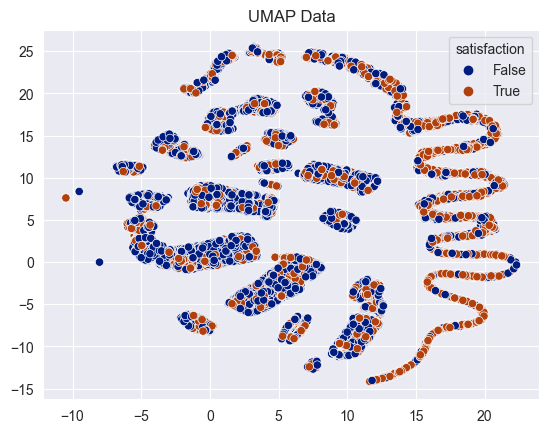

In [ ]:
# Long run time
reducer = umap.UMAP(n_neighbors=100, n_components=2, n_jobs=2)
umap_data = reducer.fit_transform(modeling_data)

sns.scatterplot(x=umap_data[:,0], y=umap_data[:, 1], hue=train['satisfaction'], palette="dark").set(title="UMAP Data")

There are clusters clearly defined but they have mixed satisfaction attributes. This means that certain data points have a big affinity among each other but they don't neccesarily have the same target result. Despite this observation, there are some clusters that have an abundance on one side or the other.

To define the One Hot Encoded Data as boolean, it's possible to filtrate the columns by the ones using underscore, since they're the only one using it because OneHotEncoder sets it by default when activating get_feature_names_out.

In [28]:
# For any of the encoded data, ensure it is boolean
for col in modeling_data.columns:
    if '_' in str(col):
        modeling_data[col] = modeling_data[col].astype('bool')

To undersample, the dataset will be analyzed for Tomek links (I. Tomek, “Two modifications of CNN,” In Systems, Man, and Cybernetics, IEEE Transactions on, vol. 6, pp 769-772, 1976.). This evaluates if a pair of data points are Tomek links and keeps just one of them, because the other one is redundant.

In [29]:
tl = TomekLinks(sampling_strategy="all", n_jobs=3)

# Remove Tomek Links
X, y = tl.fit_resample(modeling_data, train['satisfaction'])
new_modeling_data = pd.DataFrame(data=X, columns=modeling_data.columns)

In [42]:
# Evaluate size of data after Tomek Link removal
print(modeling_data.shape[0])
print(new_modeling_data.shape[0])
print("="*50)
print("Original proportion of satisfied customers:")
print(train.satisfaction.value_counts(normalize=True))
print("Proportion of satisfied customers after erasing Tomek Links")
print(y.value_counts(normalize=True))

103904
92144
Original proportion of satisfied customers:
False    0.566667
True     0.433333
Name: satisfaction, dtype: float64
Proportion of satisfied customers after erasing Tomek Links
False    0.575176
True     0.424824
Name: satisfaction, dtype: float64


There were around 11800 data points considered Tomek Links and were dropped. The proportion of satisfied customers hasn't changed so much, which is expectable because the removal of redundant information is not supposed to change the information of the dataset.

<h2> Modeling </h2>

For a first approach to the modeling of the dataset, tree-based and linear algorithms were used. This mainly due to the need of choosing techniques that are not overly sensitives to outliers for both categorical and numerical data and because of their speed.

In [35]:
classifiers = [XGBClassifier(n_jobs=4, random_state=100, categorical_feature=True), 
               LGBMClassifier(is_unbalance=True, n_jobs=4, random_state=100), 
               RandomForestClassifier(random_state=100), ExtraTreesClassifier(random_state=100),
               GradientBoostingClassifier(random_state=100), DecisionTreeClassifier(random_state=100), ExtraTreeClassifier(random_state=100),
               LogisticRegression(random_state=100), RidgeClassifier(random_state=100)]

The customized function test_classifiers prints out the F1 score and the accuracy for each model, giving an idea of the performance of each algorithm over the same data.

In [44]:
X_train, X_test, y_train, y_test = train_test_split(new_modeling_data, y, stratify=y, test_size=0.2, random_state=100)
classifier_results = test_classifiers(X_train, y_train, X_test, y_test, classifiers)

Now training XGBClassifier...
[21:10:14] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "categorical_feature" } are not used.

XGBClassifier trained in 4.877 with an F1 of : 0.972 and an accuracy of: 0.97
Now training LGBMClassifier...
LGBMClassifier trained in 0.703 with an F1 of : 0.972 and an accuracy of: 0.97
Now training RandomForestClassifier...
RandomForestClassifier trained in 8.064 with an F1 of : 0.967 and an accuracy of: 0.964
Now training ExtraTreesClassifier...
ExtraTreesClassifier trained in 9.759 with an F1 of : 0.966 and an accuracy of: 0.963
Now training GradientBoostingClassifier...
GradientBoostingClassifier trained in 14.597 with an F1 of : 0.954 and an accuracy of: 0.951
Now training DecisionTreeClassifier...
DecisionTreeClassifier trained in 0.729 with an F1 of : 0.952 and an accuracy of: 0.952
Now training ExtraTreeClassifier...
ExtraTreeClassifier trai

The classifiers with the best performances are XGBoost and LGBM. For later model optimization, the library Optuna (Optuna: A Next-generation Hyperparameter Optimization Framework. Takuya Akiba, Shotaro Sano, Toshihiko Yanase, Takeru Ohta, Masanori Koyama. 2019) will be used and the data for this is going to be stored in a compressed file.  

In [46]:
# Save off data for reading in by Optuna later
dump(value=[X_train, X_test, y_train, y_test], filename='data.joblib', compress=3)

['data.joblib']

<h2> Model Optimization </h2>

Optuna allows to optimize the hyperparameters for a model fitting into a dataset in particular. It works similarly to the Ensemble Modeling custom funcion developped for the Titanic Survival problem exposed in this Github.

The next function allows to introduce the hyperparameters for each of the models selected with different seeds and will provide the best set for the data given.

In [47]:
# Quick function for reading in the data from serialized form
def get_data():
    data = load('data.joblib')
    return data



# Using Optuna to optimally select algorithm + parameters
def optimize_objective(trial):
    
    # Read in the data that each experiment will need
    data = get_data()
    X_train = data[0]
    X_test = data[1]
    y_train = data[2]
    y_test = data[3]

    # Use Optuna to find the best algorithm to use
    algorithm = trial.suggest_categorical('algorithm', ['XGB', 'LGBM'])

    # If it wants to use XGBoost, optimize the following parameters
    if algorithm == 'XGB':
        xgb_booster = trial.suggest_categorical('xgb_booster', ['gbtree', 'dart'])
        xgb_eta = trial.suggest_float('xgb_eta', 0.1, 0.99)
        xgb_max_depth = trial.suggest_int('xgb_max_depth', 1, 1000)

        model = XGBClassifier(booster=xgb_booster, eta=xgb_eta, max_depth=xgb_max_depth, n_jobs=4, random_state=8)

    # Otherwise, it wants LGBM, so optimize these parameters
    else:
        lgbm_boosting = trial.suggest_categorical('lgbm_boosting', ['gbdt', 'rf', 'dart', 'goss'])
        lgbm_num_iterations = trial.suggest_int('lgbm_num_ierations', 10, 1000)
        lgbm_learning_rate = trial.suggest_float('lgbm_learning_rate', 0.05, 0.99)

        model = LGBMClassifier(boosting_type=lgbm_boosting, num_iterations=lgbm_num_iterations, learning_rate=lgbm_learning_rate, n_jobs=4, random_state=8)

    # Fit and score the model
    model.fit(X_train, y_train)
    score = f1_score(y_true = y_test, y_pred = model.predict(X_test), average='weighted')

    # Return the model
    return score

The objective is to maximize the metric scores chosen in the classifier evaluation function. In this case the F1 or the accuracy

In [49]:
study = optuna.create_study(direction="maximize")

study.optimize(optimize_objective, n_trials=10)

[I 2022-11-25 21:56:26,408] A new study created in memory with name: no-name-bb3b360e-1aa4-4e63-b8df-506c3cb12763
[I 2022-11-25 21:56:40,591] Trial 0 finished with value: 0.9707633318718984 and parameters: {'algorithm': 'XGB', 'xgb_booster': 'gbtree', 'xgb_eta': 0.625905209126931, 'xgb_max_depth': 371}. Best is trial 0 with value: 0.9707633318718984.
[I 2022-11-25 21:56:42,164] Trial 1 finished with value: 0.9685454871748542 and parameters: {'algorithm': 'LGBM', 'lgbm_boosting': 'goss', 'lgbm_num_ierations': 496, 'lgbm_learning_rate': 0.7506020879038496}. Best is trial 0 with value: 0.9707633318718984.
[I 2022-11-25 21:56:42,811] Trial 2 finished with value: 0.9667978325102724 and parameters: {'algorithm': 'LGBM', 'lgbm_boosting': 'gbdt', 'lgbm_num_ierations': 111, 'lgbm_learning_rate': 0.45043135026928277}. Best is trial 0 with value: 0.9707633318718984.
[I 2022-11-25 21:57:23,899] Trial 3 finished with value: 0.9711969935079293 and parameters: {'algorithm': 'XGB', 'xgb_booster': 'dar

LightGBMError: Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at D:\a\1\s\python-package\compile\src\boosting\rf.hpp, line 35 .


In [ ]:
# Quick function to get and sort the Optuna trials for the top-n
def get_optuna_trials(study, top_n):
    all_trials = study.get_trials()
    res_trials = {}
    for _t in all_trials:
        res_trials[_t.number] = (_t.value, _t.params)

    f_trials = sorted(res_trials.items(), key=lambda x: x[1][0], reverse=True)[:top_n]

    return f_trials

In [ ]:
# Get the best trial
f_trials = get_optuna_trials(study, 1)
f_trials

In [ ]:
# Using optimal parameters, train a final model
final_model = LGBMClassifier(boosting_type='dart', num_iterations=406, learning_rate=0.235)
final_model.fit(X_train, y_train)

In [ ]:
# Print metrics
print(balanced_accuracy_score(y_test, final_model.predict(X_test)))
print(f1_score(y_test, final_model.predict(X_test)))

<h2> Test dataset </h2>

After obtaining the most appropriate model with its tuned parameters, it will be trained with the full train data and used to predict wether the customers of the test dataset are satisfied or not.

In [51]:
# Read in testing data
test = pd.read_csv('../airline_satisfaction/test.csv')
# Set types
test = test.astype({k:v for k,v in types_dict.items() if k != 'satisfaction'})


# Format the testing data like we did for training
testing_labels = [1 if x=='satisfied' else 0 for x in test['satisfaction']]
test.drop(['Unnamed: 0', 'id', 'satisfaction'], inplace=True, axis=1)

# Use the SAME OHE object from earlier, and .transform, NOT .FIT_TRANSFORM!!
testing_encoded_data = pd.DataFrame(data=ohe.transform(test[cat_columns]), columns=ohe.get_feature_names_out())

# Create a dataframe of the data prepped for modeling
test_modeling_data = pd.concat([test[numerical_columns], testing_encoded_data], axis=1)

# Change types to category
for col in modeling_cat_cols:
    test_modeling_data[col] = test_modeling_data[col].astype('category')

    # For any of the encoded data, ensure it is boolean
for col in test_modeling_data.columns:
    if '_' in str(col):
        test_modeling_data[col] = test_modeling_data[col].astype('bool')

In [52]:
# Print metrics
print(balanced_accuracy_score(testing_labels, final_model.predict(test_modeling_data)))
print(f1_score(testing_labels, final_model.predict(test_modeling_data)))

NameError: name 'final_model' is not defined

In [ ]:
# Plot Confusion Matrix
ConfusionMatrixDisplay.from_estimator(final_model, test_modeling_data, testing_labels)

In [ ]:
# Run SHAP Calculations
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(test_modeling_data)

# NumPy magic to convert shap vals to usable format
abs_mean_shap = np.mean(np.array([np.absolute(np.array(shap_values[0])), np.absolute(np.array(shap_values[1]))]), axis=0)

abs_mean_shap = np.mean(np.array([np.absolute(np.array(shap_values[0])), np.absolute(np.array(shap_values[1]))]), axis=0)

# Get a dataframe of the shap values for each feature, for each sample
# Then, create an average per feature
shap_df = pd.DataFrame(data=abs_mean_shap, columns=X_test.columns)
shap_avg_df = pd.DataFrame(shap_df.mean().to_dict(),index=[shap_df.index.values[-1]])

# Reformat the dataframe
shap_plot_df = shap_avg_df.T.reset_index()
shap_plot_df.columns = ['Feature', 'Mean ABS SHAP']

In [ ]:
# Create a top 5 plot
plt.figure(figsize=(30, 20))
sns.barplot(data=shap_plot_df.sort_values(by='Mean ABS SHAP', ascending=False).head(n=5), x='Feature', y='Mean ABS SHAP', palette="dark").set(title="SHAP Values for LGBM Model")
plt.show()